# Digital sheet music analyzer

## 1 Setting environments and importing necessary packages

### Installing MuseScore 3 is necessary for visualization purposes

Download link: https://musescore.org/en/download

In [ ]:
!pip install -r requirements.txt

In [1]:
import re
import math
import numpy as np
from itertools import chain
from collections import Counter
import nltk
from nltk.util import ngrams 
from music21 import *
from pathlib import Path 
import pandas as pd
import os 
from os import listdir
from os.path import isfile, join
from itertools import groupby
import glob
from difflib import SequenceMatcher
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import display, Markdown, clear_output
# widget packages
from ipywidgets import widgets, interact
from tqdm.notebook import trange, tqdm

from tkinter import Tk, filedialog
us = environment.UserSettings()

#Only for Windows - install and add your path of MuseScore3 here
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']

#For Linux users
#us = environment.UserSettings()
#us['musescoreDirectPNGPath'] = '/usr/bin/musescore3'
#us['directoryScratch'] = '/tmp'
#us['musicxmlPath'] ='/usr/bin/musescore3'

WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

## 2 Algorithms for extracting information from digital sheet note

#### Function to convert fraction objects to floats

In [2]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        decimal = whole - frac if whole < 0 else whole + frac
        return round(decimal,3)

### Extracts measure information from sheet parts

In [3]:
def get_measure_and_notes(part):
    measures = []
    detailed_seq = [] #Whole note part sequence without meassure markings
    for e in part.getElementsByClass('Measure'):
        
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements)
        
        for elem in newMeasure[e.number]:
            off_s = elem.offset
            if elem.isNote:
                
                if not isinstance(elem.duration.quarterLength, float) or not isinstance(off_s, float):
                    
                    decimal_lenght = convert_to_float(str(elem.duration.quarterLength))
                    off_s = convert_to_float(str(off_s))
                    detailed_seq.append((e.number, str(elem.pitch.midi), decimal_lenght, off_s))
                   
                else:
                    
                    detailed_seq.append((e.number, str(elem.pitch.midi), elem.duration.quarterLength, off_s))
                
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                notes = []
                for c in elem.notes:
                    if not isinstance(c.duration.quarterLength, float) or not isinstance(off_s, float):
                        decimal_lenght = convert_to_float(str(c.duration.quarterLength))
                        off_s = convert_to_float(str(off_s))
                        notes.append((e.number, str(c.pitch.midi),decimal_lenght, off_s))
                    else:
                        notes.append((e.number, str(c.pitch.midi), c.duration.quarterLength, off_s))
                        
                detailed_seq.append(notes)
            elif elem.isRest:
                detailed_seq.append((e.number, str(elem.name) + '_'+ str(elem.duration.quarterLength)))
        
        measures.append(newMeasure)

    
    dic = {}
    
    for i in range(len(detailed_seq)):
        if len(detailed_seq[i]) != 0:
            dic[i] = detailed_seq[i]
    return dic


### Sheet note information is extracted to datatable

In [4]:
def gather_part_info(note, noteName, sheet_path, note_id, k_old, k_new):
    allNote = [] #Every part of the instrument is collected here
    part_count = 1
    for el in note.elements: #Every part is a separately analyzed -> el = PartStaff
        
        #Basic info
        partList = {}
        partList['note_id'] = note_id
        partList['note_part_id'] = str(note_id) + "_" + str(part_count)
        partList['sheet_name'] = noteName
        partList['sheet_path'] = sheet_path
        partList['part_name'] = el.partName 
        partList['original_key'] = k_old 
        
        part_count +=1
 
        partList['transposed_key'] = k_new
            
        #Find the measures and their content
        partList['measures'] = get_measure_and_notes(el)
        
        allNote.append(partList)
    
    return allNote

### Key change algoritm (to base key - C-major or a-minor)


* What method does note.transpose(i) use? - 

In [5]:
#Change all keys to either a-minor or C-major
def key_change_to_base(note): 
    
    k = note.analyze('key')
    
    
    if str(k) == "C major" or str(k) == "a minor":
        
        return k, k, note

    if 'major' in str(k):
        i = interval.Interval(k.tonic, pitch.Pitch('c5'))
    else:
        i = interval.Interval(k.tonic, pitch.Pitch('a4'))
    sNew = note.transpose(i)
    kNew = sNew.analyze('key')
        
    return k, kNew, sNew

## 3 Importing sheet notes to dataframe

### Import folder (database) of music sheets and add them to dataframe

In [6]:
# Imports all files in the directory ending with .mxl:
from tkinter import Tk, filedialog
root = Tk()
root.withdraw() #use to hide tkinter window
def search_for_file_path ():
    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True) 
    currdir = os.getcwd()
    tempdir = filedialog.askdirectory(parent=root, initialdir=currdir, title='Please select a directory')
    if len(tempdir) > 0:
        print ("You chose: %s" % tempdir)
    return tempdir

file_path_variable = search_for_file_path()

input_str = file_path_variable +'\\*.musicxml' #or .mxl
raw_string = r"{}".format(input_str)

sheets = glob.glob(raw_string)

if len(sheets) == 0:
    input_str = file_path_variable +'\\*.mxl'
    raw_string = r"{}".format(input_str)

    sheets = glob.glob(raw_string)

df_info = []
for sh in tqdm(range(len(sheets))):
    s = converter.parse(sheets[sh])
    k_old, k_new, sNew = key_change_to_base(s) #Change key to base key
    partStream2 = sNew.parts.stream()
    if len(df_info) == 0:
        idx = 0
    else:
        idx = df_info[-1]['note_id'] #Assign id to the note
    sheet_name = sheets[sh].split('\\')[-1]
    
    note_info2= gather_part_info(partStream2, sheet_name, sheets[sh], idx+1, k_old, k_new)    
    for part in note_info2:
        df_info.append(part)

df = pd.DataFrame(df_info) #build the dataframe

#Some parse errors may come due to broken/unconventional music sheets

You chose: C:/Users/Lleis/Documents/SCHOOL/digimagister/digital_sheet_music_analysis/cover_note_training


  0%|          | 0/24 [00:00<?, ?it/s]

In [14]:
df

,note_id,note_part_id,sheet_name,sheet_path,part_name,original_key,transposed_key,measures
0,1,1_1,Canon_in_D_-_Pachelbel.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,D major,C major,"{0: (1, 'rest_4.0'), 1: (2, '88', 2.0, 0.0), 2..."
1,1,1_2,Canon_in_D_-_Pachelbel.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,D major,C major,"{0: (1, 'rest_4.0'), 1: (2, '60', 0.5, 0.0), 2..."
2,2,2_1,Canon_in_D_lemontart.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,D major,C major,"{0: (1, 'rest_4.0'), 1: (2, 'rest_4.0'), 2: (3..."
3,2,2_2,Canon_in_D_lemontart.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,D major,C major,"{0: (1, '60', 0.5, 0.0), 1: (1, '67', 0.5, 0.5..."
4,3,3_1,Canon_in_D_Pachebel._Piano_Version_by_AC.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,D major,C major,"{0: (1, '88', 2.0, 0.0), 1: (1, '86', 2.0, 2.0..."
5,3,3_2,Canon_in_D_Pachebel._Piano_Version_by_AC.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,D major,C major,"{0: (1, '60', 0.5, 0.0), 1: (1, '67', 0.5, 0.5..."
6,4,4_1,Chopin_Prelude_in_E_Minor_Opus_28_No_4.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Boesendorfer Grand Piano,e minor,a minor,"{0: (0, 'rest_2.0'), 1: (0, 'rest_1.0'), 2: (0..."
7,4,4_2,Chopin_Prelude_in_E_Minor_Opus_28_No_4.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Boesendorfer Grand Piano,e minor,a minor,"{0: (0, 'rest_4.0'), 1: [(1, '60', 0.5, 0.0), ..."
8,5,5_1,F._Chopin_Prelude_in_E_minor_Opus_28_no_4_-_Ar...,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Oboe,e minor,a minor,"{0: (0, '64', 0.75, 0.0), 1: (0, '76', 0.25, 0..."
9,5,5_2,F._Chopin_Prelude_in_E_minor_Opus_28_no_4_-_Ar...,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Guitar,e minor,a minor,"{0: (0, 'rest_1.0'), 1: [(1, '60', 0.5, 0.0), ..."


In [50]:
with pd.option_context('display.max_colwidth', 30):
    display(df.head(10))

,note_id,note_part_id,sheet_name,sheet_path,part_name,original_key,transposed_key,measures
0,1,1_1,Canon_in_D_-_Pachelbel.mxl,C:/Users/Lleis/Documents/S...,Piano,D major,C major,"{0: (1, 'rest_4.0'), 1: (2..."
1,1,1_2,Canon_in_D_-_Pachelbel.mxl,C:/Users/Lleis/Documents/S...,Piano,D major,C major,"{0: (1, 'rest_4.0'), 1: (2..."
2,2,2_1,Canon_in_D_lemontart.mxl,C:/Users/Lleis/Documents/S...,Piano,D major,C major,"{0: (1, 'rest_4.0'), 1: (2..."
3,2,2_2,Canon_in_D_lemontart.mxl,C:/Users/Lleis/Documents/S...,Piano,D major,C major,"{0: (1, '60', 0.5, 0.0), 1..."
4,3,3_1,Canon_in_D_Pachebel._Piano...,C:/Users/Lleis/Documents/S...,Piano,D major,C major,"{0: (1, '88', 2.0, 0.0), 1..."
5,3,3_2,Canon_in_D_Pachebel._Piano...,C:/Users/Lleis/Documents/S...,Piano,D major,C major,"{0: (1, '60', 0.5, 0.0), 1..."
6,4,4_1,Chopin_Prelude_in_E_Minor_...,C:/Users/Lleis/Documents/S...,Boesendorfer Grand Piano,e minor,a minor,"{0: (0, 'rest_2.0'), 1: (0..."
7,4,4_2,Chopin_Prelude_in_E_Minor_...,C:/Users/Lleis/Documents/S...,Boesendorfer Grand Piano,e minor,a minor,"{0: (0, 'rest_4.0'), 1: [(..."
8,5,5_1,F._Chopin_Prelude_in_E_min...,C:/Users/Lleis/Documents/S...,Oboe,e minor,a minor,"{0: (0, '64', 0.75, 0.0), ..."
9,5,5_2,F._Chopin_Prelude_in_E_min...,C:/Users/Lleis/Documents/S...,Guitar,e minor,a minor,"{0: (0, 'rest_1.0'), 1: [(..."


## 4 Longest Common Consequtive Non-overlapping Subsequence

#### Find the longest common, consequtive and non-overlapping subsequences between notes

### Sheet music information extracting and transformation algorithms for LCCNOSS analysis

#### Measures are assembled as following: - [a,b,c,d]

* a - measure nr. / index
* b - MIDI mark of the note (can retreive note pitch and note octave from it)
* c - duration of the note
* d - float = off-beat note/element, integer = on-beat note/element

### Removing rests

In [7]:
def remove_rests(lst):
    new_lst =[]
    for elem in lst:
        if 'rest_' not in elem[1][1]:
            new_lst.append(elem)
    return new_lst

### Removing off-beat notes

In [8]:
def remove_offbeat(lst):
    
    #lst_new = remove_rests(lst) - Why we have to remove rests while removing offbeats?
    new_lst = []
    for elem in lst:
        
        #el[1] - sheet element (chord, rest, note)
        #CHORDS
        if isinstance(elem[1], list):
            if elem[1][0][-1].is_integer(): # integer - meaning that note is on beat
                new_lst.append(elem)
    
        else:
            #RESTS
            if 'rest_' in elem[1][1]:
                new_lst.append(elem)
            
            #NOTES
            else:
                if elem[1][-1].is_integer():
                    new_lst.append(elem)
    
    return new_lst

### Removing repetitive notes

In [9]:
def remove_repetitive_notes(lst):
    new_lst =[]
    repeated_notes = []
    for elem in lst:
        if not isinstance(elem[1], list):
            if 'rest_' not in elem[1][1]:
                if len(new_lst) != 0:
                    if new_lst[-1][1][1] != elem[1][1]:
                        new_lst.append(elem)
                    else:
                        repeated_notes.append(elem)
                else:
                    new_lst.append(elem)
            else:
                new_lst.append(elem)
        else:
            new_lst.append(elem)
    return new_lst

### Construct the string from note information

For [3] and [4] - they show the index positionis from where the list should be split.

**Possible values of variables:**

* n -> measure list from dataframe row
* if_rest -> True: keep the rests, False: remove the rests
* if_chords -> True: keep the chords, False: remove the chords and keep only the lowest note of the chord
* o = 2 -> if note duration is NOT taken into account OR o = 3 -> if note duration IS taken into account
* offset -> True: keep the offset notes, False: remove offset notes 
* repetition -> True: keep the repetitive notes, False: remove the repetitive (aka consequtive same) notes
* oct_val -> showing the convertion of note to higher or lower octave

In [10]:
def construct_strings(n, if_rest, if_chords, o, offset, repetition, oct_val):
    
    n = ([(k, n[k]) for k in n]) #change dict to list value
   
    #Remove repetition first if needed
    if repetition == False:
        n = remove_repetitive_notes(n)
    
    lst = []
    lst_keys = []
    if offset == False: 
        n = remove_offbeat(n)
   
    if if_rest:
        n = remove_rests(n)
        
    
    for el in n:
        
        #CHORDS
        if isinstance(el[1], list):
            if if_chords: #Takes the upper note of the chord into account
                elem = el[1][-1][1:o]
                if o == 2:
                    #print(elem)
                    new_tup = (str(int(elem[0]) + oct_val),)
                    #print(new_tup)
                else:
                    #print(elem)
                    new_tup = (str(int(elem[0]) + oct_val), elem[1])
                    #print(new_tup)
                s = ' '.join(map(str, new_tup))
                lst.append(s)
                lst_keys.append(el[0])
            else: #Takes the whole chord into account
                cover_lst = []
                for e in el[1]:
                    if o == 2:
                        elem = e[1:o]
                        new_tup = (str(int(elem[0]) + oct_val),)
                        cover_lst.append(new_tup)
                        
                    
                    else:
                        elem = e[1:o]
                        new_tup = (str(int(elem[0]) + oct_val), elem[1])
                        #print(new_tup)
                        
                    cover_lst.append(new_tup)
                s = ' '.join(map(str,cover_lst))
                lst.append(s)
                lst_keys.append(el[0])
        
        else:
            #RESTS
            if 'rest_' in el[1][1]:
                s = ' '.join(map(str,el[1][1:2]))
                lst.append(s)
                lst_keys.append(el[0])
            #NOTES
            else:
                note_val = el[1][1:o]
                if o == 2:
                    #print(note_val)
                    new_tup = (str(int(note_val[0]) + oct_val),)
                    #print(new_tup)
                else:
                    #print(note_val)
                    new_tup = (str(int(note_val[0]) + oct_val), note_val[1])
                    #print(new_tup)
                    
                s = ' '.join(map(str, new_tup))
                lst.append(s)
                lst_keys.append(el[0])
   
    return lst, lst_keys

### Generating n-grams and matching sequences:

In [11]:
def generate_ngrams(s, n):
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    
    ngrams = zip(*[s[i:] for i in range(n)])
    
    return [ngram for ngram in ngrams]

def match_seq(list1,list2):
    output=[]
    s = SequenceMatcher(None, list1, list2)
    
    blocks=s.get_matching_blocks()
    for bl in blocks:
        for bi in range(bl.size):
            cur_a=bl.a+bi
            cur_b=bl.b+bi
            output.append((cur_a,cur_b))
    return output

def matched_seq_analysis(a, b, ngram, a_keys, b_keys):
    
    matched_seq=[]
    
    a_gram = generate_ngrams(a,ngram)
    b_gram = generate_ngrams(b,ngram)
    
    
    for x,y in match_seq(a_gram,b_gram): #x and y represent the 'order number of the specific note'
        
        k = list(a_gram[x])
        k2 = list(b_gram[y])
        
        idxs_a = [(i, i+len(k)) for i in range(len(a)) if a[i:i+len(k)] == k]
        idxs_b = [(i, i+len(k2)) for i in range(len(b)) if b[i:i+len(k2)] == k2]
        
        a_gram_keys = a_keys[idxs_a[0][0]:idxs_a[0][1]]
        b_gram_keys = b_keys[idxs_b[0][0]:idxs_b[0][1]]
        
        matched_seq.append((x,y, a_gram[x],b_gram[y], a_gram_keys, b_gram_keys))
        
    return matched_seq

## Find Different Longest Consecutive Non-Overlapping Subsequences between two strings

### Finding the longest common subsequence (starting from 4-gram)

In [12]:
def LCCNOS_combinations(a,b):
    
    lst_of_matched_seqs = []
    counter = 4 #Starting to look for 4-grams and above
    total_matches = []
    if len(a) > len(b):
        
        total = len(b[0])
        
        total_matches = []
        while counter <= total: 
            matched = matched_seq_analysis(a[0], b[0], counter, a[1], b[1])
            if len(matched) == 0:
                break
            else:
                total_matches = matched
            
                
            counter +=1 
    else:
        
        total = len(a[0])
        total_matches = []
        while counter <= total:
            matched = matched_seq_analysis(a[0],b[0], counter, a[1], b[1])
            if len(matched) == 0:
                break
            else:
                total_matches = matched
     
            counter +=1 
    
    #LCCNOS algorithm
    if len(total_matches) == 0:
        return 0, 0, 0, 0
    else:
        idx1 = total_matches[0][0]
        idx2 = total_matches[0][1]
        seq_length = len(total_matches[0][3])

        found_matches = []

        range_1 = list(range(idx1, idx1+(counter-1)))
        range_2 = list(range(idx2, idx2+(counter-1)))

        while seq_length >= 4:
            
            matched = matched_seq_analysis(a[0], b[0], seq_length, a[1], b[1])

            for match in matched:

                if match[0] not in range_1 or match[1] not in range_2:
                    
                    found_matches.append(match)
                    range_1 = range_1 + list(range(match[0], match[0]+seq_length))
                    range_2 = range_2 + list(range(match[1], match[1]+seq_length))
                    range_1.sort()
                    range_2.sort()
            seq_length= seq_length - 1
                
        if len(found_matches) == 0:
            found_matches_length = 0
            found_matches = 0
        else:
            found_matches_length = len(found_matches)
        
        
        return total_matches, len(total_matches[0][3]), found_matches, found_matches_length

In [13]:
def LCCNOS(n1, n2, if_rest, if_chords, o, offset, repetition):
    a = construct_strings(n1, if_rest, if_chords, o, offset, repetition, 0) 
    b = construct_strings(n2, if_rest, if_chords, o, offset, repetition, 0)
    
    
    b_upper = construct_strings(n2, if_rest, if_chords, o, offset, repetition, 12) 
    b_lower = construct_strings(n2, if_rest, if_chords, o, offset, repetition, -12) 
    
    
    normal_oct = LCCNOS_combinations(a,b)
    upper_oct = LCCNOS_combinations(a,b_upper)
    lower_oct = LCCNOS_combinations(a,b_lower)
    
    if normal_oct[1] >= upper_oct[1] and normal_oct[1] >= lower_oct[1]:
        return normal_oct
    elif upper_oct[1] >= normal_oct[1] and upper_oct[1] >= lower_oct[1]:
        return lower_oct
    else:
        return lower_oct
    

## Matching the longest common sequences

### Possible methods:

* Rests:<br>
   a) Keep the rests in the note sequeneces <br>
   b) Remove all the rests from the note sequences <br><br>

* Chords<br>
a) Leave chords as they are - KITSENDUS (võimalik oleks ka kõik akordi noodid lisada või siis määrata ära akordi tähtsaim noot? -> .root()) <br>
b) Only take account the first note (higher note) of the chord (chord can be harmony starting from 2 consequently sounding notes)<br><br>

* Note duration<br>
a) Consider note duration in the sequence matching<br>
b) Do not consider note duration (note can be in any duration as long as it is the same consequtive note - then it will match)<br><br>

* Offset notes<br>
a) Leave offset (not on beat notes) into the sheet<br>
b) Remove all notes that do not fall on beat<br><br>

* Repetition <br>
a) Same consequitive notes are kept<br>
b) Same consequtive notes are removed<br>

### Datatable   
   
LCCNOS = Longest Common Consequtive Non-Overlapping Sequence

### Construct the rules for LCCNOS method

In [14]:
def construct_LCCNOS(df_base, df_target, i, y, complete, parameters):
    
    helper_dictionary = {2: 'False', 3: 'True'}
    #Test for only one LCS method

    if not complete:
        
        key = str(df_target['note_part_id'][i] + ' + ' + df_base['note_part_id'][y])
        
        #Example method - change it and choose your own
        if parameters[2]:
            note_duration = 3
        else:
            note_duration = 2
        
        
        method = str(parameters[0])[0] + str(parameters[1])[0] + helper_dictionary[note_duration][0] + str(parameters[3])[0] + str(parameters[4])[0]  
        LCS_x, l, lccnos, l_lccnos = LCCNOS(df_target['measures'][i],df_base['measures'][y], parameters[0], parameters[1], note_duration, parameters[3], parameters[4])
        
        data = {'note_part_ids': key,'LCS': LCS_x, 'length_LCS': l, 'LCCNOS': lccnos, 'size_LCCNOS': l_lccnos, 'method_id': method, 'remove_rests':str(parameters[0]),'remove_chords':str(parameters[1]),
                                   'consider_note_duration':helper_dictionary[note_duration], 'consider_offset_notes':str(parameters[3]), 'consider_repetition':str(parameters[4])}
        
        df_whole = pd.DataFrame([data])
        
    else:
    
    #Computes all the possible method variants
        rests = [True, False]
        chords = [True, False]
        note_duration = [2,3]
        offset_notes = [True, False]
        repetition = [True, False]

        lst_of_rows =[]
        for a in rests:
            for b in chords:
                    for c in note_duration:
                        for d in offset_notes:
                            for e in repetition:

                                method = str(a)[0]+str(b)[0]+helper_dictionary[c][0]+str(d)[0]+str(e)[0]
                                #print(method)
                                key = str(df_target['note_part_id'][i] + ' + ' + df_base['note_part_id'][y])
                                
                                if df_target['sheet_name'][i] != df_base['sheet_name'][y]:

                                    LCS_x, l, lccnos, l_lccnos = LCCNOS(df_target['measures'][i],df_base['measures'][y],a,b,c,d,e)

                                    data = {'note_part_ids': key,'LCS': LCS_x, 'length_LCS': l, 'LCCNOS':lccnos, 'size_LCCNOS':l_lccnos, 'method_id':method, 'remove_rests':a,'remove_chords':b,
                                           'consider_note_duration':helper_dictionary[c], 'consider_offset_notes':d, 'consider_repetition':e}

                                    lst_of_rows.append(data)
        df_whole = pd.DataFrame(lst_of_rows)
                        
    return df_whole

In [15]:
#Look for similar sequence between two different notes OR against all the notes in the dataframe
def LCCNOS_analysis(df_base, df_target, i, one_note_bool, if_complete, parameters):
    df_whole = pd.DataFrame()
    note_dict = {}
    
    if one_note_bool != -1: #Compare to all the notes in the dataframe
        
        y =  one_note_bool
        df_whole = construct_LCCNOS(df_base, df_target, i, y, if_complete, parameters)
        
    else: #Compare to specific note in the dataframe (based on index)
        for y in range(len(df_base)):
            #no need to check for note_part_id match, because they are different anyways
            df_part = construct_LCCNOS(df_base, df_target, i, y, if_complete, parameters)
            df_whole = df_whole.append(df_part, ignore_index = True) 
                
    return df_whole

### Import note you want to compare against the dataframe notes

#### Input note itself shouldn't be in the dataframe

In [16]:
from tkinter import messagebox
root = Tk()
root.withdraw() #use to hide tkinter window
def search_for_file_path():
    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True) 
    currdir = os.getcwd()
    tempfile = filedialog.askopenfilename(parent=root, initialdir=currdir, title='Please select a .mxl file')

    if tempfile=='':
        return messagebox.showinfo("Faili avamine", "Ühtegi faili ei valitud või fail on tühi. Vali MusicXML-fail")
    elif  tempfile.lower().endswith(('.musicxml', '.mxl')) == False:
        return messagebox.showinfo("Vale fail", "Sisestatud fail on vale, sisesta MusicXML-fail.")
    else:
        print ("You chose: %s" % tempfile)
    return tempfile


file_path_variable = search_for_file_path()

You chose: C:/Users/Lleis/Documents/SCHOOL/digimagister/digital_sheet_music_analysis/cover_note_test/Lacrimosa.mxl


In [17]:
df_input_note = pd.DataFrame()
s = converter.parse(file_path_variable)
k_old, k_new, sNew = key_change_to_base(s) #Change key to base key
partStream2 = sNew.parts.stream()

idx = 0

sheet_name = str(file_path_variable).split('/')[-1]

note_info2= gather_part_info(partStream2, sheet_name, file_path_variable, idx+1, k_old, k_new)    
df_input_note = pd.DataFrame(note_info2)
df_input_note
#df_input_note['measures'].iloc[0]

,note_id,note_part_id,sheet_name,sheet_path,part_name,original_key,transposed_key,measures
0,1,1_1,Lacrimosa.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,d minor,a minor,"{0: (1, 'rest_0.5'), 1: (1, '80', 0.5, 0.5), 2..."
1,1,1_2,Lacrimosa.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,d minor,a minor,"{0: (1, 'rest_6.0'), 1: (2, 'rest_6.0'), 2: [(..."
2,1,1_3,Lacrimosa.mxl,C:/Users/Lleis/Documents/SCHOOL/digimagister/d...,Piano,d minor,a minor,"{0: [(1, '45', 1.0, 0.0), (1, '57', 1.0, 0.0)]..."


## Choose a method from the options:

In [18]:
import ipywidgets as widgets

wid1 = widgets.Checkbox(
    value=False,
    description='Remove rests',
    disabled=False
)
wid2 = widgets.Checkbox(
    value=False,
    description='Remove chords',
    disabled=False
)

wid3 = widgets.Checkbox(
    value=True,
    description='Consider note duration',
    disabled=False
)

wid4 = widgets.Checkbox(
    value=True,
    description='Consider offset notes',
    disabled=False
)

wid5 = widgets.Checkbox(
    value=True,
    description='Consider repetitive notes',
    disabled=False
)


items = [wid1,wid2, wid3, wid4, wid5]
left_box = widgets.VBox([items[0], items[1]])
middle_box = widgets.VBox([items[2], items[3]])
right_box = widgets.VBox([items[4]])
widgets.HBox([left_box, middle_box, right_box])

### LCCNOS_analysis (dataframe, input_note_idx, target_note_idx, methods_boolean):

* dataframe - Choose the dataframe (by default: 'df')
* input_note_idx - Choose a note part you want to analyze based on df_input_note dataframe index (by default: 0)
* target_note_idx - Choose a target note index you want to compare the input note against OR write -1 for analysis against all the notes in the dataframe
* methods_boolean - TRUE - note part will be compared with all the 32 methods, FALSE - note part will be compared with one chosen method in 'parameters'
* parameters - checked boxes of method options





### <font color='blue'>Do you want to compare the note with all the methods or only chosen one?</font>

In [19]:
layout = widgets.Layout(width='auto', height='40px') #set width and height

wid6 = widgets.Checkbox(
    value=False,
    description='Compare note parts with every (32 different) method combination',
    disabled=False,
    layout=layout,
    indent=False,
)
items = [wid6]
left_box = widgets.VBox([items[0]])
widgets.HBox([left_box])

### <font color='blue'>Choose - do you want to use all parts in the comparison (value: -1) or a specific part (choose input note part index value - default: 0)</font>

In [20]:
input_note_idx = -1 #Add the note index here what you want to compare:

### <font color='blue'>Choose - do you want to compare with all the notes (value: -1) or a specific note (choose target note index value)</font>

In [21]:
target_note_idx = -1 #Change the value here

In [22]:
if input_note_idx == -1:
    df_whole = pd.DataFrame()
    for i in range(len(df_input_note)):
        parameters = [wid1.value, wid2.value, wid3.value, wid4.value, wid5.value]
        df_part = LCCNOS_analysis(df, df_input_note, i, target_note_idx, wid6.value, parameters) 
        df_whole = df_whole.append(df_part, ignore_index = True)
    df_whole = df_whole.sort_values(['length_LCS', 'size_LCCNOS'], ascending=[False, False])
        
else:

    parameters = [wid1.value, wid2.value, wid3.value, wid4.value, wid5.value]
    df_whole = LCCNOS_analysis(df, df_input_note, input_note_idx, target_note_idx, wid6.value, parameters)
    #df_whole = df_whole.append(df_part, ignore_index = True)
    df_whole = df_whole.sort_values(['length_LCS', 'size_LCCNOS'], ascending=[False, False])
    df_whole
        

In [23]:
df_whole

,note_part_ids,LCS,length_LCS,LCCNOS,size_LCCNOS,method_id,remove_rests,remove_chords,consider_note_duration,consider_offset_notes,consider_repetition
496,1_1 + 8_1,"[(0, 0, (rest_0.5, 80, 81, rest_0.5, 88, 89, r...",24,0,0,FTFTT,False,True,False,True,True
497,1_1 + 8_1,"[(0, 0, (rest_0.5, 80, 81, rest_0.5, 88, 89, r...",24,0,0,FTFTF,False,True,False,True,False
500,1_1 + 8_1,"[(0, 0, (rest_0.5, 80 0.5, 81 0.5, rest_0.5, 8...",24,0,0,FTTTT,False,True,True,True,True
501,1_1 + 8_1,"[(0, 0, (rest_0.5, 80 0.5, 81 0.5, rest_0.5, 8...",24,0,0,FTTTF,False,True,True,True,False
504,1_1 + 8_1,"[(0, 0, (rest_0.5, 80, 81, rest_0.5, 88, 89, r...",24,0,0,FFFTT,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
4987,1_3 + 24_2,0,0,0,0,FFFFF,False,False,False,False,False
4988,1_3 + 24_2,0,0,0,0,FFTTT,False,False,True,True,True
4989,1_3 + 24_2,0,0,0,0,FFTTF,False,False,True,True,False
4990,1_3 + 24_2,0,0,0,0,FFTFT,False,False,True,False,True


In [24]:
df_whole = df_whole.sort_values('length_LCS').drop_duplicates('note_part_ids', keep='last').sort_values('length_LCS', ascending=False)
inputs = []
outputs = []
for i in range(len(df_whole)):
    splitted_note_names = df_whole['note_part_ids'].iloc[i].split()
   
    note1 = splitted_note_names[0]
    note2 = splitted_note_names[2]
    
    n1_name = df_input_note.loc[df_input_note['note_part_id'] == note1]['sheet_name'].values[0]
    n2_name = df.loc[df['note_part_id'] == note2]['sheet_name'].values[0]
    
    inputs.append(n1_name)
    outputs.append(n2_name)


df_1 = pd.DataFrame({'input_note': inputs})
df_2 = pd.DataFrame({'target_note': outputs})


df_whole['input_note'] = inputs
df_whole['target_note'] = outputs 

df_new = df_whole

df_new = df_new.drop(df_new.columns[[1, 3, 4, 5, 6, 7, 8,9,10]], axis=1)  # df.columns is zero-based pd.Index
df_new[:30]

,note_part_ids,length_LCS,input_note,target_note
496,1_1 + 8_1,24,Lacrimosa.mxl,Lacrimosa_-_Requiem.mxl
760,1_1 + 12_1,24,Lacrimosa.mxl,Mozart_Lacrimosa.mxl
1373,1_1 + 20_1,24,Lacrimosa.mxl,W._A._Mozart_-_Lacrimosa_-_Requiem_Mass_in_d_m...
560,1_1 + 9_1,23,Lacrimosa.mxl,Lacrimosa_original_transcription_for_piano_-_M...
2401,1_2 + 12_1,17,Lacrimosa.mxl,Mozart_Lacrimosa.mxl
3009,1_2 + 20_1,17,Lacrimosa.mxl,W._A._Mozart_-_Lacrimosa_-_Requiem_Mass_in_d_m...
2144,1_2 + 8_1,17,Lacrimosa.mxl,Lacrimosa_-_Requiem.mxl
3860,1_3 + 8_2,11,Lacrimosa.mxl,Lacrimosa_-_Requiem.mxl
3924,1_3 + 9_2,11,Lacrimosa.mxl,Lacrimosa_original_transcription_for_piano_-_M...
4720,1_3 + 20_2,11,Lacrimosa.mxl,W._A._Mozart_-_Lacrimosa_-_Requiem_Mass_in_d_m...


## 4 Visualization

### Algorithms for visualizing subs

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def check_int (sub1, sub2):
    if isinstance(sub1, int) and isinstance(sub2, int):
        return sub1, sub2
    else:
        if isinstance(sub1, tuple) and isinstance(sub2, tuple):
            return sub1[0], sub2[0]
        else:
            if isinstance(sub1, tuple):
                return sub1[0], sub2
            else:
                return sub1, sub2[0]
            

def visualize_subs(name1, name2, part_id_1, part_id_2, seq1, seq2):
    
    #if it's a Bach corpus note or note from local directory
    if 'bwv' in name1:
        s1 = corpus.parse('bach/'+name1)
    else:
        s1 = converter.parse(name1)
        
    if 'bwv' in name2:
        s2 = corpus.parse('bach/'+name2)
    else:
        s2 = converter.parse(name2)
    
    k_old, k_new, sNew1 = key_change_to_base(s1)
    partStream1 = sNew1.parts.stream()
    k_old, k_new, sNew2 = key_change_to_base(s2)
    partStream2 = sNew2.parts.stream()
      
    #print(seq1)
    #print(seq2)
    print('-----')
    print('Length of the similar note sequence is: ' + str(len(seq1)))
    
    measure_start_1, measure_end_1 = check_int(seq1[0][0],seq1[-1][0])
    measure_start_2, measure_end_2 = check_int(seq2[0][0],seq2[-1][0])
    

    sNew1.parts[int(part_id_1)-1].measures(measure_start_1, measure_end_1).show()
    sNew2.parts[int(part_id_2)-1].measures(measure_start_2, measure_end_2).show()
    
    sNew1.parts[int(part_id_1)-1].measures(measure_start_1, measure_end_1).show('midi')
    sNew2.parts[int(part_id_2)-1].measures(measure_start_2, measure_end_2).show('midi')
    
    
    return sNew1.parts[int(part_id_1)-1].measures(measure_start_1, measure_end_1).plot().run(), sNew2.parts[int(part_id_2)-1].measures(measure_start_2, measure_end_2).plot().run()

## References back to original notes 

In [26]:
def separate_note_names(notes):
    
    splitted_note_names = notes.split()
   
    note1 = splitted_note_names[0]
    note2 = splitted_note_names[2]

    return note1, note2

def get_actual_notes(notes, idxs):
    
    actual_notes = []
    for i in idxs:
        actual_notes.append(notes[i])
    
    return actual_notes

def get_whole_actual_seq(notes, idxs):
    
    actual_seq = []
    
    start_id = idxs[0]
    end_id = idxs[-1]
    
    while start_id != end_id:
        actual_seq.append(notes[start_id])
        start_id= start_id +1 
      
    return actual_seq
        
def get_notes(notes, lcs, df_base, df_target):
    
    note1, note2 = separate_note_names(notes)
    part_a_measures = df_target.loc[df_target['note_part_id'] == note1]['measures'].values[0]
    part_b_measures = df_base.loc[df_base['note_part_id'] == note2]['measures'].values[0]
    
   
    print(lcs)
    
    part_a_notes_idxs  = lcs[0][4]
    part_b_notes_idxs  = lcs[0][5]
    
  
    
    #Notes without indexes
    part_a_actual_notes = get_actual_notes(part_a_measures,part_a_notes_idxs)
    part_b_actual_notes = get_actual_notes(part_b_measures,part_b_notes_idxs)
    
    
        
    part_a_actual_seq = get_whole_actual_seq(part_a_measures,part_a_notes_idxs)
    part_b_actual_seq = get_whole_actual_seq(part_b_measures,part_b_notes_idxs)
 
    if df_base['sheet_path'].values[0] == 'corpus':
        
        n1_name = df_target.loc[df_target['note_part_id'] == note1]['sheet_name'].values[0]
        n2_name = df_base.loc[df_base['note_part_id'] == note2]['sheet_name'].values[0]
        
    else:
        
        n1_name = df_target.loc[df_target['note_part_id'] == note1]['sheet_path'].values[0]
        n2_name = df_base.loc[df_base['note_part_id'] == note2]['sheet_path'].values[0]

    splitted_note_names = notes.split()
    
    part_id_1 = splitted_note_names[0].split('_')[-1]
    part_id_2 = splitted_note_names[2].split('_')[-1]
        
    visualize_subs(n1_name, n2_name, part_id_1, part_id_2, part_a_actual_notes, part_b_actual_notes)

## Visualizing all the longest repeating non-overlapping unique subsequences 

In [27]:
df_idx = 0 # Change this value here

if df_whole['LCCNOS'].iloc[df_idx] != 0:
    get_notes(df_whole['note_part_ids'].iloc[df_idx], df_whole['LCCNOS'].iloc[df_idx], df, df_input_note)
else:
    print("Value is empty.")
    

Value is empty.


## Visualizing best match of longest common subsequence

#### Change the df_idx number if you want to visualize a specific result

[(0, 0, ('rest_0.5', '80', '81', 'rest_0.5', '88', '89', 'rest_0.5', '81', '80', 'rest_0.5', '91', '89', 'rest_0.5', '88', '93', 'rest_0.5', '89', '86', 'rest_0.5', '83', '84', 'rest_0.5', '88', '80'), ('rest_0.5', '80', '81', 'rest_0.5', '88', '89', 'rest_0.5', '81', '80', 'rest_0.5', '91', '89', 'rest_0.5', '88', '93', 'rest_0.5', '89', '86', 'rest_0.5', '83', '84', 'rest_0.5', '88', '80'), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])]
-----
Length of the similar note sequence is: 24


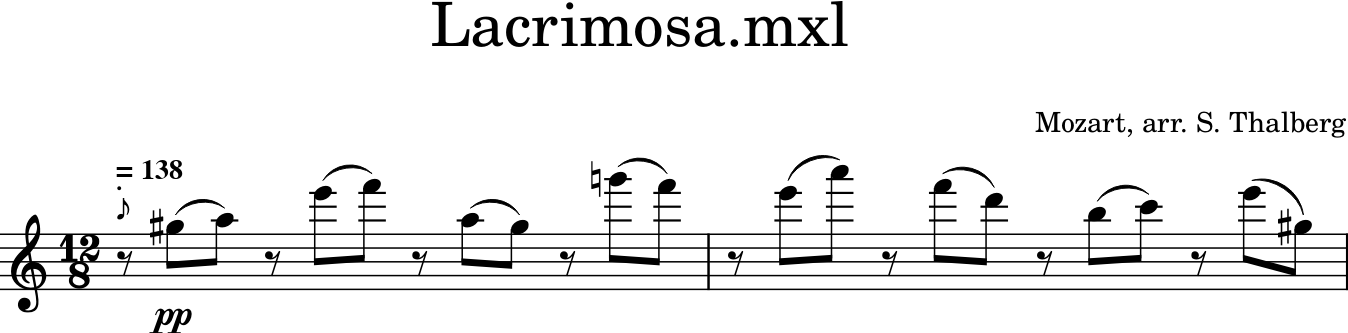

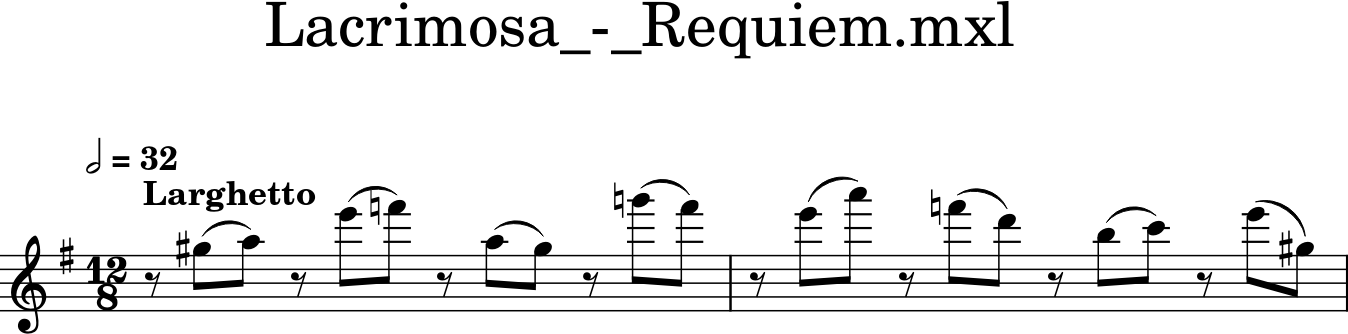

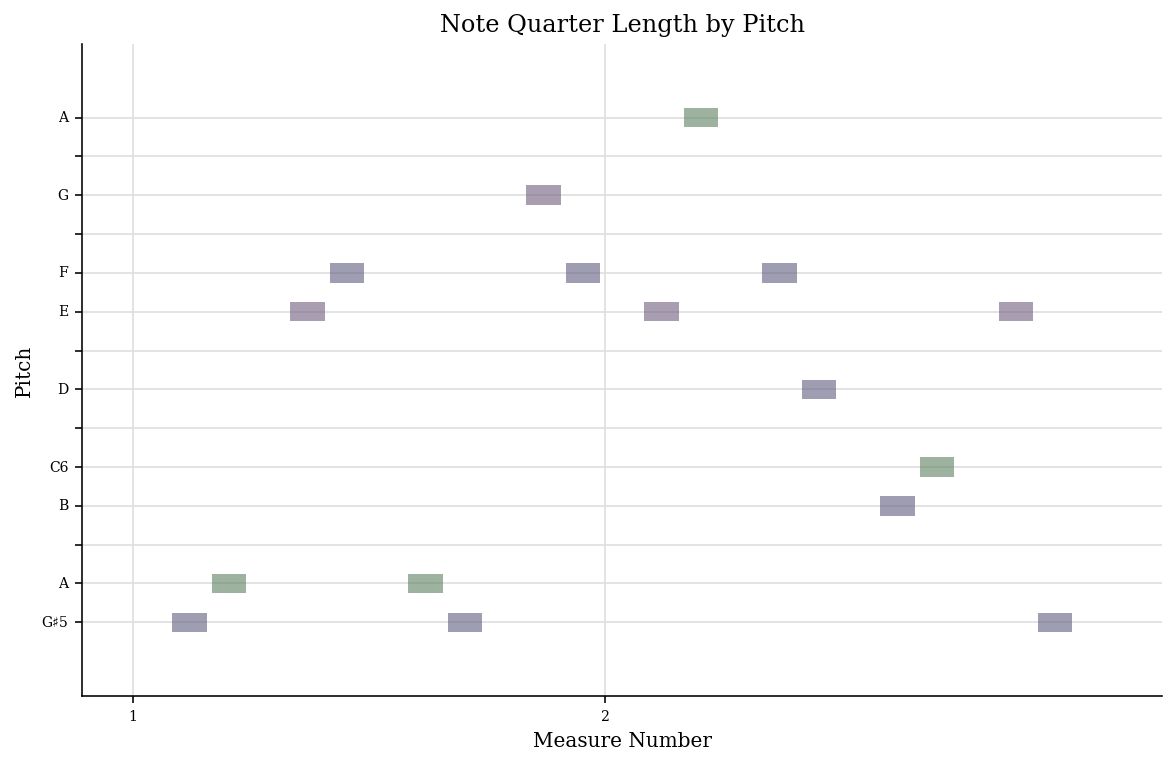

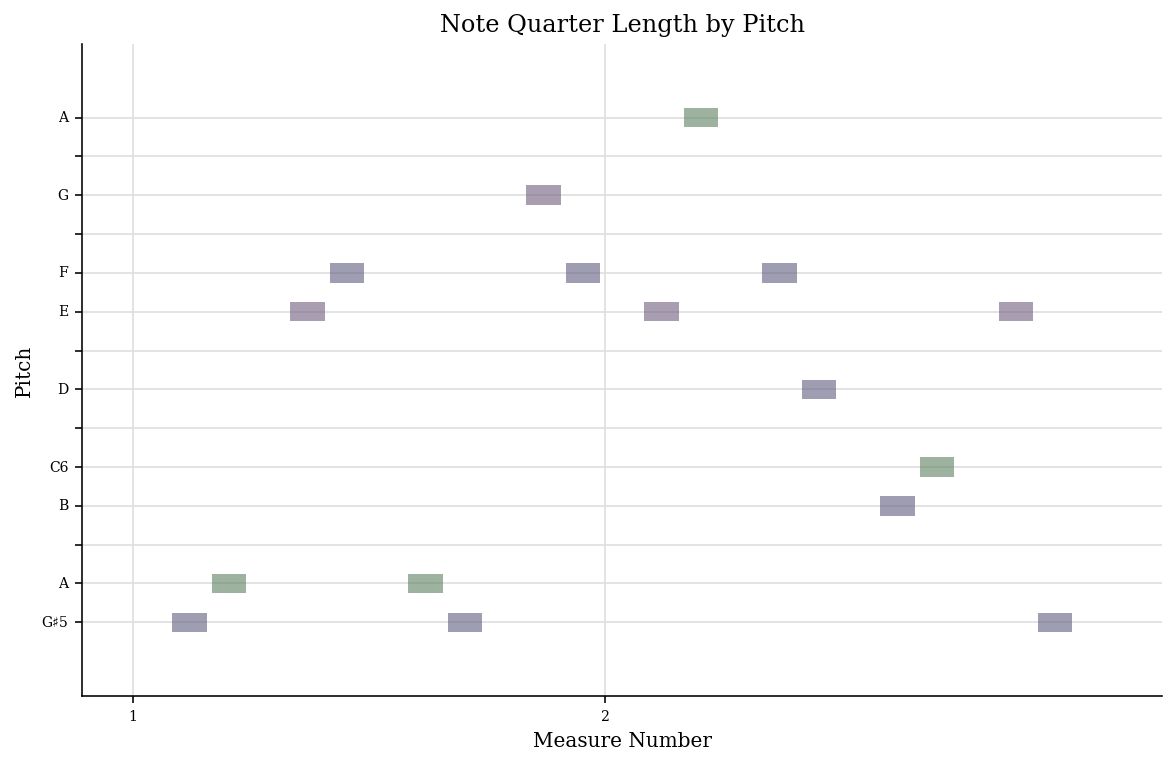

In [28]:
df_idx = 0 # Change this value here

get_notes(df_whole['note_part_ids'].iloc[df_idx], df_whole['LCS'].iloc[df_idx], df, df_input_note)

****

# End of notebook